#  A/B Testing

This week's lab will focus on A/B Testing.

In modern data analytics, deciding whether two numerical samples come from the same underlying distribution is called A/B testing. 

The name refers to the labels of the two samples, A and B.


In [3]:
# Run this cell to set up the notebook, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', (FutureWarning, np.VisibleDeprecationWarning))


## 1. A/B Testing

We will develop the method in the context of an example. The data come from a sample of newborns in a large hospital system. 

#### Question: Do the two sets of values come from the same underlying distribution?

Answering this question by performing a statistical test is called A/B testing.



### Comparing Two Samples

* Compare values of sampled individuals in `Group A` with values of sampled individuals in `Group B`.


### Example: Smoking, Ladies, & Babies

The table births contains the following variables for 1,174 mother-baby pairs: 

* Random samples of mothers of newborns.

Compare:
    
    (A) Birth weights of babies of mothers who smoked during pregnancy
    
    (B) Birth weights of babies of mothers who didn't smoke


In [6]:
births = Table.read_table('baby.csv')
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


## Comparing Two Samples

In [7]:
smoking_and_birthweight = births.select('Maternal Smoker', 'Birth Weight')
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


In [8]:
smoking_and_birthweight.group('Maternal Smoker')


Maternal Smoker,count
False,715
True,459


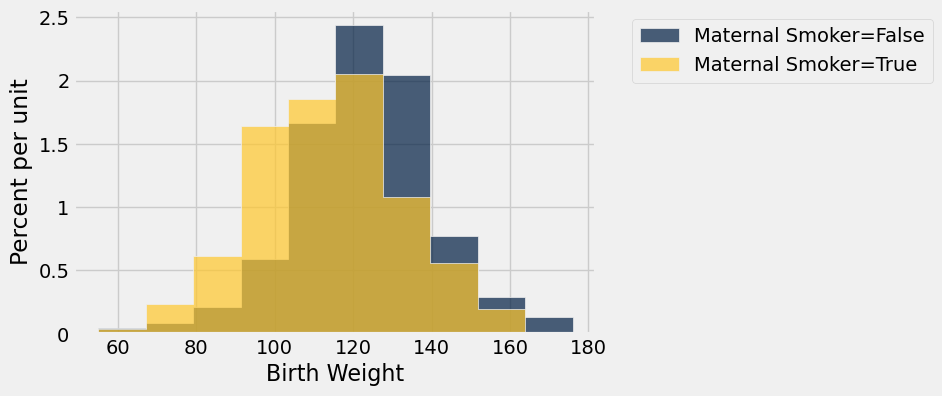

In [9]:
smoking_and_birthweight.hist('Birth Weight', group = 'Maternal Smoker')

In [10]:
means_table = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_table

Maternal Smoker,Birth Weight average
False,123.085
True,113.819


## Test Statistic

What values of our statistic are in favor of the alternative: positive or negative?

In [11]:
means = means_table.column(1)
observed_difference = means.item(0) - means.item(1)
observed_difference

9.266142572024918

In [12]:
def difference_of_means(table, group_label):
    """Takes: name of table,
    column label that indicates the group to which the row belongs
    Returns: Difference of mean birth weights of the two groups"""
    reduced = table.select('Birth Weight', group_label)
    means_table = reduced.group(group_label, np.average)
    means = means_table.column(1)
    return means.item(1) - means.item(0)

In [13]:
difference_of_means(births, 'Maternal Smoker')

-9.266142572024918

In [14]:
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


#### Question: could the difference be due to chance alone?

### The following statements are the steps of an A/B hypothesis test:

1. Define a `null` and `alternate` model
2. Choose a test statistic (typically the difference in means between two categories)
3. Find the value of the `observed test statistic`
4. `Shuffle` the labels of the original sample, find your `simulated test statistic`, and repeat many times

5. Calculate the `p-value` based off your observed and simulated test statistics

6. Use the `p-valu`e and `p-value cutoff` to draw a conclusion about the null hypothesis

### Hypotheses

`Null Hypothesis`: in the population, the distributions of the birth weights of the babies in the two groups are the same (They are different in the smaple just due to chance alone)

`Alternative`: in the population, the babies of the mothers who didn't smoke were heavier, on average, than the babies of the smokers

### Test Statistic

* Group A: non-smokers
* Group B: smokers

`Test Statistic`: Difference between average weights, where Group A = smokers, Group B = non-smokers

`Statistic`: Difference between average weights

* Group B average - Group A Average
* Weight of non-smokers - weight of smokers



#### Now, let's simulate under the null hypothesis!

If the null is true, all rearrangements of the birth weights among the two groups are equally likely

#### Plan:

* Shuffle all the birth weights
* Assign some to "Group A" and the rest to "Group B", maintaining the two sample sizes
* Find the difference between the averages of the two shuffled groups
* Repeat



## Simulation Under Null Hypothesis
## Generating Random Samples

### From an array of values (evaluates to the sample array):
    np.random.choice(array, sample_size)


### From the rows of a table (evaluates to the sample table):
    tbl.sample(sample_size)(default method: with replacement)
    tbl.sample(sample_size, with_replacement=False)
    tbl.sample(with_replacement=False) shuffles the table by randomly permuting all the rows

### From a categorical distribution (evaluates to the sample distribution):
    sample_proportions(sample_size, population_distribution)
    
    
#### To simulate a statistic many times:
* Define a function that returns one simulated value
* Make an empty collection array
* Run a for loop:
    Each time, call the function
    Append the newly simulated value to the collection array

In [17]:
weights = smoking_and_birthweight.sample(with_replacement = False)
weights

Maternal Smoker,Birth Weight
True,117
False,138
False,163
True,104
False,131
True,116
True,117
True,143
False,144
False,119


In [21]:
shuffled_labels = smoking_and_birthweight.sample(with_replacement = False).column(0)

shuffled_labels 


array([False,  True,  True, ...,  True,  True, False], dtype=bool)

In [22]:
original_and_shuffled = smoking_and_birthweight.with_column('Shuffled Label', shuffled_labels)

original_and_shuffled


Maternal Smoker,Birth Weight,Shuffled Label
False,120,False
False,113,True
True,128,True
True,108,True
False,136,False
False,138,True
False,132,False
False,120,False
True,143,False
False,140,False


In [23]:
shuffled_only = original_and_shuffled.select('Birth Weight','Shuffled Label')
shuffled_group_means = shuffled_only.group('Shuffled Label', np.average)
shuffled_group_means

Shuffled Label,Birth Weight average
False,119.842
True,118.871


In [24]:
difference_of_means(original_and_shuffled, 'Shuffled Label')

-0.9704983469689239

In [25]:
difference_of_means(original_and_shuffled, 'Maternal Smoker')

-9.266142572024918

## Permutation Test

In [27]:
def one_simulated_difference_of_means():
    """Returns: Difference between mean birthweights
    of babies of smokers and non-smokers after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = births.sample(with_replacement=False).column('Maternal Smoker')
    
    # table of birth weights and shuffled labels
    shuffled_table = births.select('Birth Weight').with_column(
        'Shuffled Birth Weight', shuffled_labels)
    
    return difference_of_means(shuffled_table, 'Shuffled Birth Weight')   


In [28]:
one_simulated_difference_of_means()

-1.5428584487408017

In [29]:
differences = make_array()

repetitions = 5000
for i in np.arange(repetitions):
    new_difference = one_simulated_difference_of_means()
    differences = np.append(differences, new_difference) 
differences 

array([ 0.36739339,  1.08999802,  0.15275835, ...,  0.51048342,
        1.5335771 ,  2.43146701])

The histogram below shows the distribution of these 5,000 values. It is the empirical distribution of the test statistic simulated under the null hypothesis. 

Observed Difference: 9.266142572024918
Observed Difference: 9.266142572024918


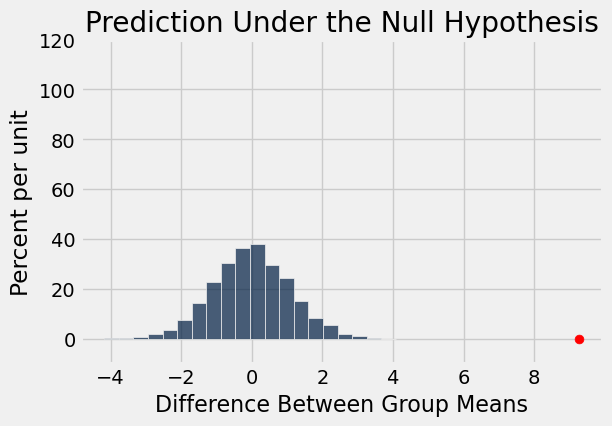

In [30]:

Table().with_column('Difference Between Group Means', differences).hist(bins = 20)
print('Observed Difference:', observed_difference)

# Plotting parameters; you can ignore the code below
plots.ylim(-0.1, 1.2)
plots.scatter(observed_difference, 0, color='red', s=40, zorder=3)
plots.title('Prediction Under the Null Hypothesis')
print('Observed Difference:', observed_difference)


In [31]:
empirical_p = np.count_nonzero(differences <= observed_difference) / repetitions
empirical_p

1.0

The empirical p-value is 1, meaning that none of the 5,000 permuted samples resulted in a difference of 9.27 or lower.

Our data supports the alternative hypothesis that the babies of the mothers who didn't smoke were heavier, on average, than the babies of the smokers

Any observed different was due to something besides just chance.

Under the `null model`, there should be no statistically significant difference between the grouped means. 

If you want to compute an empirical p-value, remember that low values of the statistic favor the alternative hypothesis.

##  Definition of the p-value


### Formal name: observed significance level

The p-value is the chance (probability),

* under the null hypothesis,
* that the test statistic
* is equal to the value that was observed in the data
* or is even further in the direction of the alternative.


p-value is high → evidence of consistency with the null

p-value is low → more evidence for the alternative

## The p-Value as an Area

`Empirical distribution` of the test statistic under the null hypothesis.

* Red dot denotes the observed statistic.
* Yellow area denotes the tail probability (p-value).

## Another Permutation Test

We can use the same method to compare other attributes of the smokers and the non-smokers, such as their ages. 

Histograms of the ages of the two groups show that in the sample, the mothers who smoked tended to be younger.

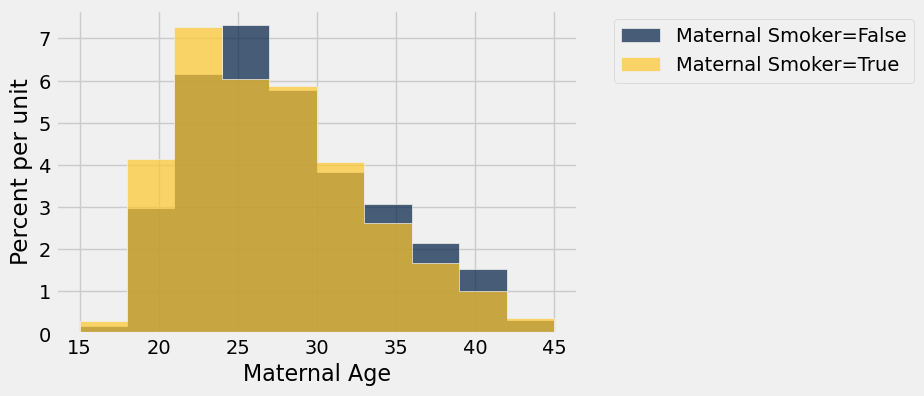

In [72]:
smoking_and_age = births.select('Maternal Smoker', 'Maternal Age')
smoking_and_age.hist('Maternal Age', group = 'Maternal Smoker')

In [73]:
def difference_of_means(table, group_label):
    """Takes: name of table,
    column label that indicates the group to which the row belongs
    Returns: Difference of mean ages of the two groups"""
    reduced = table.select('Maternal Age', group_label)
    means_table = reduced.group(group_label, np.average)
    means = means_table.column(1)
    return means.item(1) - means.item(0)

In [74]:
observed_age_difference = difference_of_means(births, 'Maternal Smoker')
observed_age_difference

-0.8076725017901509

Is this difference due to chance, or does it reflect an underlying difference in the population?


As before, we can use a permutation test to answer this question. If the underlying distributions of ages in the two groups are the same, then the empirical distribution of the difference based on permuted samples will predict how the statistic should vary due to chance.

We will follow the same process as in any simulation. We will start by writing a function that returns one simulated value of the difference between means, and then write a for loop to simulate numerous such values and collect them in an array.

In [75]:
  # array of shuffled labels
shuffled_labels = births.sample(with_replacement=False).column('Maternal Smoker')
shuffled_labels 

array([False, False, False, ..., False, False, False], dtype=bool)

In [76]:
 # table of ages and shuffled labels
shuffled_table = births.select('Maternal Age').with_column('Shuffled Label', shuffled_labels)
shuffled_table

Maternal Age,Shuffled Label
27,False
33,False
28,False
23,True
25,True
33,False
23,True
25,False
30,True
27,False


In [77]:
def one_simulated_difference_of_means():
    """Returns: Difference between mean ages
    of smokers and non-smokers after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = births.sample(with_replacement=False).column('Maternal Smoker')
    
    # table of ages and shuffled labels
    shuffled_table = births.select('Maternal Age').with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, 'Shuffled Label')  

In [78]:
age_differences = make_array()

repetitions = 5000
for i in np.arange(repetitions):
    new_difference = one_simulated_difference_of_means()
    age_differences = np.append(age_differences, new_difference)

Observed Difference: -0.8076725017901509


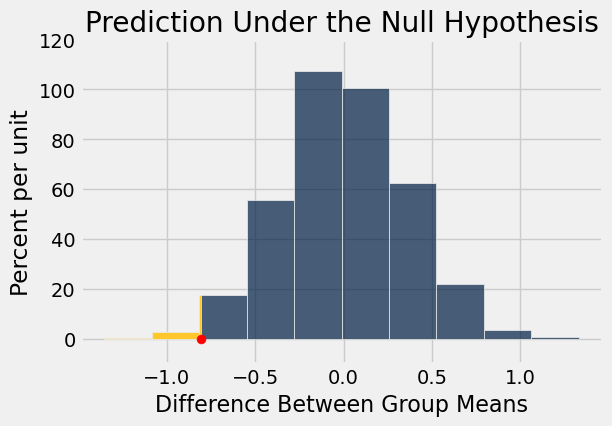

In [79]:
Table().with_column(
    'Difference Between Group Means', age_differences).hist(
    right_end = observed_age_difference)
# Plotting parameters; you can ignore the code below
plots.ylim(-0.1, 1.2)
plots.scatter(observed_age_difference, 0, color='red', s=40, zorder=3)
plots.title('Prediction Under the Null Hypothesis')
print('Observed Difference:', observed_age_difference)

In [116]:
empirical_p = np.count_nonzero(age_differences <= observed_age_difference) / 5000
empirical_p

0.0094

The empirical p-value is around 1% and therefore the result is statistically significant. The test supports the hypothesis that the smokers were younger on average.

## Who is Older?
Data scientists have drawn a simple random sample of size 500 from a large population of adults. 
Each member of the population happened to identify as either "male" or "female". 

Data was collected on several attributes of the sampled people, including age. 

The table sampled_ages contains one row for each person in the sample, with columns containing the individual's gender identity.

In [32]:
sampled_ages = Table.read_table('age.csv')
sampled_ages

Gender,Age
male,23
male,29
male,29
female,49
female,33
male,31
male,60
male,38
female,60
female,27


In [33]:
num_females = sampled_ages.group('Gender')
num_females

Gender,count
female,260
male,240


In [34]:
num_females = sampled_ages.group('Gender').column(1).item(0)
num_females

260

In [35]:
group_mean_tbl = sampled_ages.group('Gender', np.average)
group_mean_tbl


Gender,Age average
female,42.0692
male,43.3833


In [36]:
group_means = group_mean_tbl.column(1)
group_means

array([ 42.06923077,  43.38333333])

### null hypothesis and alternative hypothesis. 

* In the population, the males and females have the same distribution of ages; the sample averages of the two groups are different due to chance.

* The males in the population are older than the females, on average.

In [37]:
observed_statistic_ab = group_means.item(1) - group_means.item(0)

observed_statistic_ab

1.314102564102562

In [87]:
shuffled_labels = sampled_ages.select('Gender').sample(with_replacement=False).column(0) 
original_with_shuffled_labels = sampled_ages.with_columns('Shuffled Label', shuffled_labels)
original_with_shuffled_labels

Gender,Age,Shuffled Label
male,23,male
male,29,female
male,29,male
female,49,female
female,33,male
male,31,male
male,60,male
male,38,male
female,60,female
female,27,male


In [38]:
def simulate_one_statistic():
    "Returns one value of our simulated test statistic"
    shuffled_labels = sampled_ages.select('Gender').sample(with_replacement=False).column(0) 
    shuffled_tbl = sampled_ages.select('Age').with_columns('Shuffled Label', shuffled_labels) 

    group_means = shuffled_tbl.group('Shuffled Label', np.average).column(1) 
    return group_means.item(1) - group_means.item(0) 

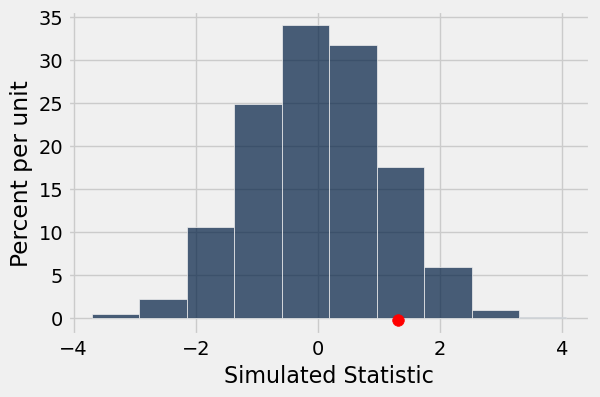

In [39]:
repetitions = 5000
simulated_statistics_ab = make_array()

for i in np.arange(repetitions):
    simulated_statistics_ab = np.append(simulated_statistics_ab, simulate_one_statistic()) 


Table().with_columns('Simulated Statistic', simulated_statistics_ab).hist()
plots.scatter(observed_statistic_ab, -0.002, color='red', s=70);

In [105]:
p_val = np.count_nonzero(simulated_statistics_ab >= observed_statistic_ab) / 5000
p_val

0.8928

In [115]:
0 <= p_val <= 1

True

'The data are consistent with the null hypothesis.'